In [1]:
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from method_utils import load_dataset
from method_utils import get_generators
from method_utils import get_distances
from method_utils import get_gramian
from method_utils import normalize_distances

from scipy.linalg import expm
from scipy.stats import entropy

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

### Load dataset

In [2]:
dataset_name = 'syn_15_120'

# location: 'datasets' or 'temporal_networks'
location = 'datasets'

vertices, edges, adj_matrices, labels = load_dataset(dataset_name, loc=location)

In [3]:
L = get_generators(adj_matrices)

### Plot 10 largest eigenvalues of generators $L_{\alpha}$.

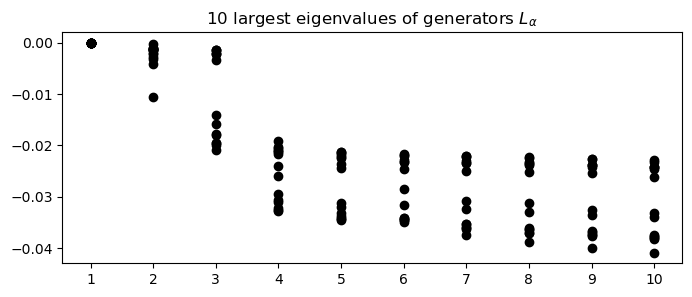

In [4]:
plt.figure(figsize=(8,3))
plt.title("10 largest eigenvalues of generators $L_{\\alpha}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

for n in range(len(L)):
    L_eigvals, L_eigvecs = np.linalg.eig(L[n])
    L_eigvals_sorted = np.sort(L_eigvals)[-10:][::-1]
    plt.scatter(x=x_axis, y=L_eigvals_sorted, c='black')

In [5]:
tau = 100

### Compute $P_{\alpha}^{\tau}$ for all snapshots $0\leq\alpha\leq M-1$.

In [6]:
P_tau = np.array([expm(L[n]*tau) for n in range(len(L))])

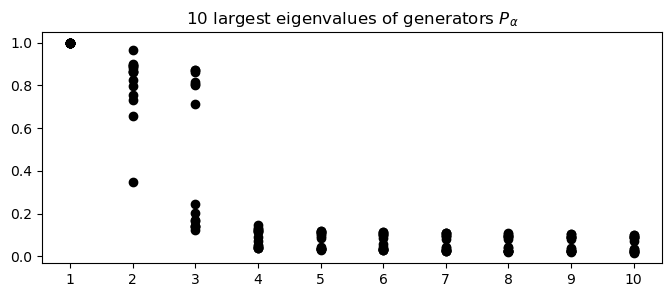

In [7]:
plt.figure(figsize=(8,3))
plt.title("10 largest eigenvalues of generators $P_{\\alpha}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

for n in range(len(L)):
    P_eigvals, P_eigvecs = np.linalg.eig(P_tau[n])
    P_eigvals_sorted = np.sort(np.real(P_eigvals))[-10:][::-1]
    plt.scatter(x=x_axis, y=P_eigvals_sorted, c='black')

### Compute matrix $K$

Computing distances: 100%|##########| 15/15 [00:00<00:00, 4753.65it/s]


<Axes: >

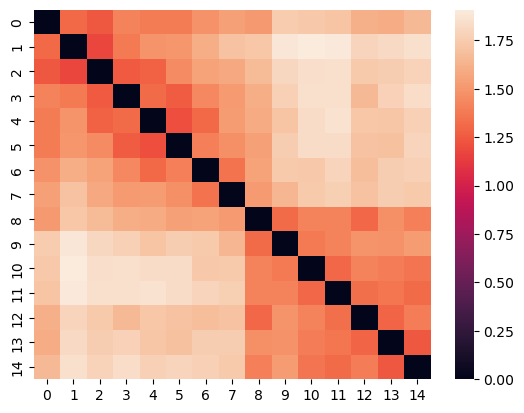

In [8]:
distances = get_distances(P_tau)
sn.heatmap(distances)

### Compute optimal $\sigma$

In [9]:
def relative_variance(sigma):

    K = get_gramian(distances, sigma)
    
    # Step 1: Mask out the diagonal
    off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]

    # Step 2: Compute variance
    variance = np.var(off_diagonal_entries)
    mean = np.mean(off_diagonal_entries)

    return variance/mean

def uniformity_score(sigma, bins=20):

    K = get_gramian(distances, sigma)
    
    # Step 1: Mask out the diagonal
    off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]
    int_size = np.max(off_diagonal_entries) - np.min(off_diagonal_entries)

    counts, _ = np.histogram(off_diagonal_entries, bins=bins, range=(np.min(off_diagonal_entries), np.max(off_diagonal_entries)), density=False)
    probs = counts / counts.sum()
    return int_size * entropy(probs, base=np.e) / np.log(bins)

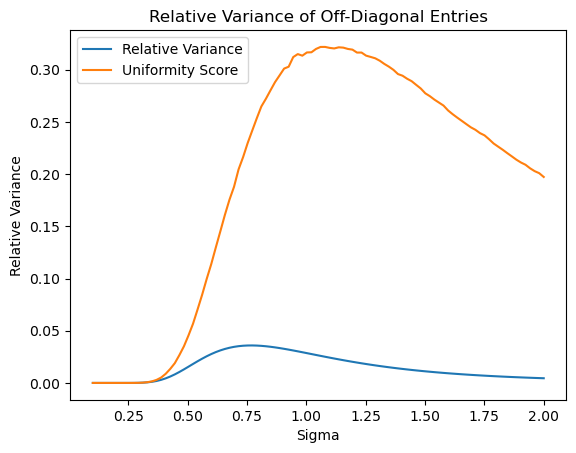

Optimal sigma (relative variance): 0.7717171717171717
Optimal sigma (uniformity): 1.0787878787878789


Max relative variance: 0.03588723537264924
Max uniformity: 0.32178385471760373


In [10]:
sigma_values = np.linspace(0.1, 2, 100)
relative_variances = [relative_variance(sigma) for sigma in sigma_values]
uniformity_scores = [uniformity_score(sigma) for sigma in sigma_values]
plt.plot(sigma_values, relative_variances)
plt.plot(sigma_values, uniformity_scores)
plt.legend(['Relative Variance', 'Uniformity Score'])
plt.xlabel('Sigma')
plt.ylabel('Relative Variance')
plt.title('Relative Variance of Off-Diagonal Entries')
plt.show()

sigma_max_variance = sigma_values[np.argmax(relative_variances)]
sigma_max_uniformity = sigma_values[np.argmax(uniformity_scores)]
relative_variance_max = np.max(relative_variances)
uniformity_score_max = np.max(uniformity_scores)
print(f"Optimal sigma (relative variance): {sigma_max_variance}")
print(f"Optimal sigma (uniformity): {sigma_max_uniformity}")
print("\n")
print(f"Max relative variance: {relative_variance_max}")
print(f"Max uniformity: {uniformity_score_max}")

In [11]:
sigma = 0.77

Relative variance: 0.03589031317807702


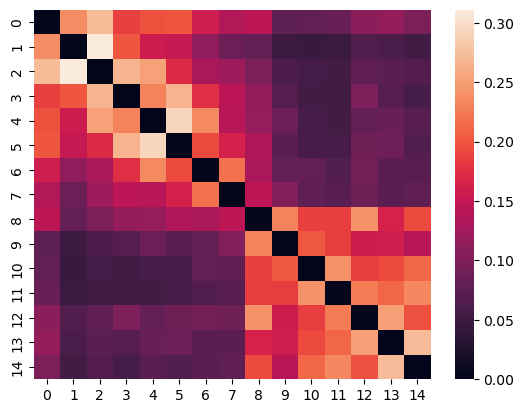

In [12]:
K = get_gramian(distances, sigma)
np.fill_diagonal(K, 0)

sn.heatmap(K)

# Step 1: Mask out the diagonal
off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]

# Step 2: Compute variance
variance = np.var(off_diagonal_entries)
mean = np.mean(off_diagonal_entries)
print(f"Relative variance: {variance/mean}")

### Compute temporal generator $L_{temp}$.

In [13]:
L_temp = get_generators(K)

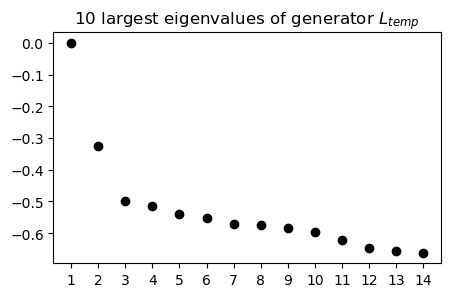

In [14]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generator $L_{temp}$")
x_axis = np.arange(1,15)
plt.xticks(x_axis)

L_temp_eigvals, L_temp_eigvecs = np.linalg.eig(L_temp)
L_temp_eigvals_sorted = np.sort(L_temp_eigvals)[-14:][::-1]
plt.scatter(x=x_axis, y=L_temp_eigvals_sorted, c='black')

### Set $\tau_{temp}$ and compute $P_{temp}^{\tau_{temp}}$

In [15]:
tau_temp = 2.5
P_temp = expm(L_temp*tau_temp)

Text(0.5, 1.0, 'Transition matrix $P_{temp}^{\\tau_{temp}}$')

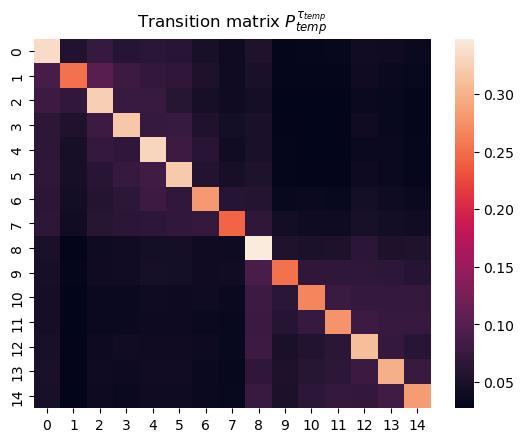

In [16]:
ax = sn.heatmap(P_temp)
ax.set_title("Transition matrix $P_{temp}^{\\tau_{temp}}$")

### Spectral clustering of $P^{\tau_{temp}}_{temp}$.

Determine dominant eigenvalues of transition matrix $P^{\tau}_{temp}$

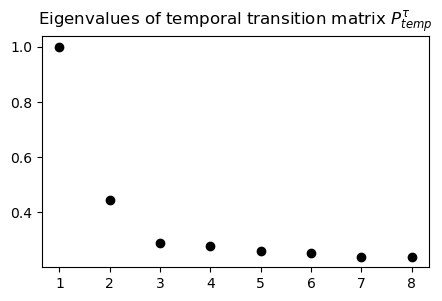

In [17]:
P_temp_eigval, P_temp_eigvec = np.linalg.eig(P_temp)
indices = np.argsort(P_temp_eigval)[-8:][::-1]
P_temp_eigval_sorted = P_temp_eigval[indices]
P_temp_eigvec_sorted = P_temp_eigvec[:, indices]

plt.figure(figsize=(5, 3))
plt.title("Eigenvalues of temporal transition matrix $P_{temp}^{\\tau}$")
plt.xticks(np.arange(1,9))
plt.scatter(np.arange(1, 9), P_temp_eigval_sorted, c='black')

### Get snapshot embeddings

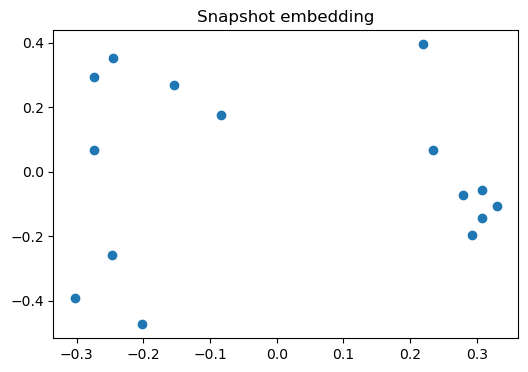

In [18]:
dominant_eigenvalues = 2

data = P_temp_eigvec_sorted[:, :dominant_eigenvalues]

plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(6,4))
plt.title("Snapshot embedding")
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1])

### Perform spectral clustering

In [19]:
kmeans = KMeans(n_clusters=dominant_eigenvalues, n_init=10, random_state=0)
kmeans.fit(np.real(data))

predicted_labels = kmeans.labels_

### Compute ARI score

In [20]:
ari = adjusted_rand_score(labels, predicted_labels)
print(f"ARI score: {ari}")

ARI score: 1.0


### Compute NMI score

In [21]:
nmi = normalized_mutual_info_score(labels, predicted_labels)
print(f"NMI score: {nmi}")

NMI score: 1.0


### Get Distance matrix (LNE)

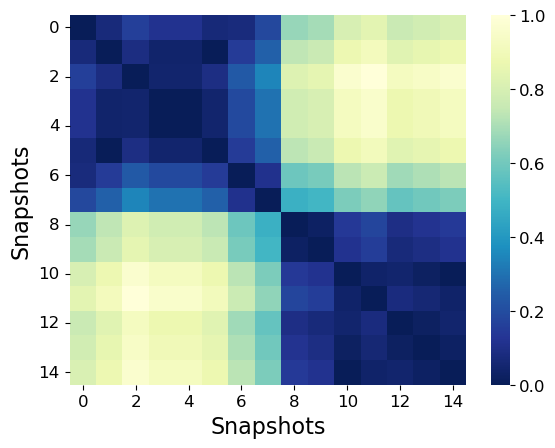

In [22]:
distance_matrix = np.zeros(shape=(len(adj_matrices), len(adj_matrices)))

for i in range(len(adj_matrices)):
    for j in range(len(adj_matrices)):
        distance_matrix[i, j] = np.linalg.norm(data[i,:] - data[j,:])

distance_matrix_norm, min_distance, max_distance = normalize_distances(distance_matrix)

ax = sn.heatmap(distance_matrix_norm, annot=False, annot_kws={"size": 16}, cmap="YlGnBu_r")
#ax.set_title(f"Distance matrix of {dataset_name} dataset; $\\tau={tau}$, $\sigma={sigma}$, $\\tau_{{temp}}={tau_temp}$")

# Specify the ticks you want
x_ticks_labels = [0, 2, 4, 6, 8, 10, 12, 14]  # corresponding labels
x_ticks_positions = np.array(x_ticks_labels) + 0.5 # positions (index)

y_ticks_labels = [0, 2, 4, 6, 8, 10, 12, 14]
y_ticks_positions = np.array(y_ticks_labels) + 0.5

# Set them
ax.set_xticks(x_ticks_positions)
ax.set_xticklabels(x_ticks_labels, fontsize=12)

ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(y_ticks_labels, fontsize=12)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Set axis labels
ax.set_xlabel("Snapshots", fontsize=16)
ax.set_ylabel("Snapshots", fontsize=16)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

### Snapshot embedding (clustered)

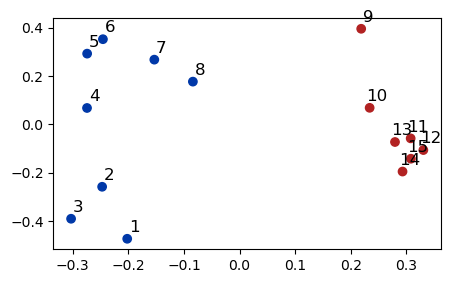

In [23]:
colors = ["#B22222", "#FFBF00", "#0038A8"]
#colors = ["#0038A8", "#B22222"]
my_cmap = ListedColormap(colors)

plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(5,3))
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1], c=predicted_labels, cmap=my_cmap)
# plt.ylim(-0.2, 0.2)

# Annotate each point by its plotting order
for i, (xi, yi) in enumerate(zip(plot_coordinates[:,0], plot_coordinates[:,1]), start=1):
    if i % 1 == 0:
        plt.annotate(str(i), (xi, yi), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12)